# About classification and `ImageDataGenerator`

This post gives a few comments on how to use `ImageDataGenerator` for testing a model in Keras.


I have been working on the Chapter 5 of *Deep Learning with Python*. However, I had some issues regarding how to use the trained model to classify images (dogs and cats). Training the model is relatively simple. In previous chapters, the authors employed the `fit` function for training. Alhought, in this chapter, the author introduces the `fit_generator` function for two reasons:

1. To show how to train your model using a larger dataset (by *larger* we mean one that cannot fit enterily in memory).
2. To show how to use data augmentation for better generalization. Data augmentation allows us to increase the number of samples for the model by modifying existing samples via random transformations that yield believable-lookin images. That way, the model is never exposed to the same image/sample twice. From [pyimagesearch](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/): Performing data augmentation is a form of regularization, enabling our model to generalize better.

The training process is as follows:

```python
# --- train model ---
model.fit_generator(
                train_generator,
                steps_per_epoch=100,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=50)
```

Here, we supply the input samples (images and labels) via generators: `train_generator` for training, and `validation_generator` for validation. Both generators are defined below:


```python
# --- data preprocessing ---
train_datagen = ImageDataGenerator(rescale=1./255)      # rescale images by 1/255 
test_datagen  = ImageDataGenerator(rescale=1./255)      # so the values are in the range [0, 1]


train_dir = "/media/data/dogs_vs_cats_small/train"
train_generator = train_datagen.flow_from_directory(train_dir,                          # path of images
                                                    target_size=(input_h, input_w),     # image size
                                                    batch_size=20,                      # number of images per batch
                                                    class_mode="binary"                 # because you use binary_crossentropy, you need binary labels
                                                    )

validation_dir = "/media/data/dogs_vs_cats_small/validation"
validation_generator = train_datagen.flow_from_directory(validation_dir,                # path of images
                                                    target_size=(input_h, input_w),     # image size
                                                    batch_size=20,                      # number of images per batch
                                                    class_mode="binary"                 # because you use binary_crossentropy, you need binary labels
                                                    )
```

As it can be seen, the only difference between them is the path of the images. A generator is employed to fed the samples (images and labels) into the model in batches. The number of batches is determined by `batch_size`. The path of the images, `train_dir` and `validation_dir`, must follow a structure of directories, where each directory represents a class. For instance, in the dataset for the dogs vs. cats challenge, this is the structure:

```
/media/data/dogs_vs_cats_small/train
    dogs/           
    cats/
    
/media/data/dogs_vs_cats_small/validation
    dogs/           
    cats/
```




1. How to use a generator to classify a single batch with `ImageDataGenerator` and `model.predict()`.
2. How to use a generator to classify a test split (multiple batches) with `ImageDataGenerator` and `model.predict_generator()`.
3. How to determine the label name of the predictions given by a model via `model.predict()` and `model.predict_generator()`.

In all these cases, we assume that a model is already trained. Thus, we will use `load_model()` for loading the model and make prediction on unseen data.


----

**tl;dr** This snippet shows how to use a generator to test the model using `flow_from_directory()` and `predict_generator()`:

```python
n_images = 1000
batch_size = 20
steps = int(n_images/batch_size)


# create image data generator to preprocess input images
test_dir = "/media/data/dogs_vs_cats_small/test"              # we assume this path contains a directory for each class
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,                         # path of test images
                                                  target_size=(input_h, input_w),   # shape expected by the model
                                                  color_mode="rgb",
                                                  class_mode="binary",
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42,
                                                 )
# prediction using batches
pred = model.predict_generator(test_generator, steps=steps)
```

-----


## Show images

First, let's display a few images from the dataset.

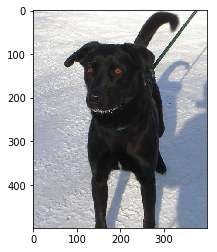

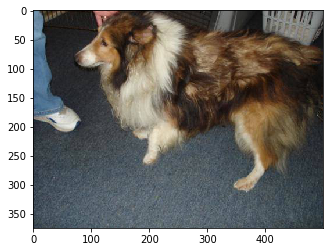

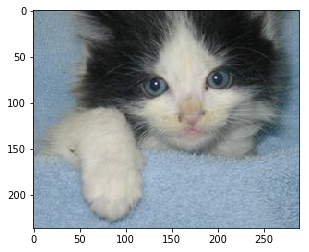

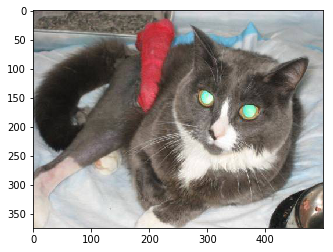

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import os

input_h = 150       # image height
input_w = 150       # image width
show_images = True

# --- paths ----
# train (cats):       /media/data/dogs_vs_cats_small/train/cats
# train (dogs):       /media/data/dogs_vs_cats_small/train/dogs
# validation (cats):  /media/data/dogs_vs_cats_small/validation/cats
# validation (dogs):  /media/data/dogs_vs_cats_small/validation/dogs
# test (cats):        /media/data/dogs_vs_cats_small/test/cats
# test (dogs):        /media/data/dogs_vs_cats_small/test/dogs

# --- display images (they are not preprocessed yet) ---
test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]

if show_images:

    # convert PIL to np.array (cast to np.int in the range [0, 255])
    img_path = fnames_dogs[4]
    img = image.load_img(img_path)
    x = image.img_to_array(img).astype(int)
    plt.figure()
    plt.imshow(x)

    # convert PIL to np.array (as np.float32 in the range [0, 1])
    img_path = fnames_dogs[5]
    img = image.load_img(img_path)
    x = image.img_to_array(img) * 1./255
    plt.figure()
    plt.imshow(x)
    
    # convert PIL to np.array (cast to np.int in the range [0, 255])
    img_path = fnames_cats[4]
    img = image.load_img(img_path)
    x = image.img_to_array(img).astype(int)
    plt.figure()
    plt.imshow(x)

    # convert PIL to np.array (as np.float32 in the range [0, 1])
    img_path = fnames_cats[5]
    img = image.load_img(img_path)
    x = image.img_to_array(img) * 1./255
    plt.figure()
    plt.imshow(x)

    plt.show()

## Classify a single batch

In this section, we will perform these tasks:

1. Load the model.
2. Create a batch of 32 images of dogs and 32 of cats.
3. Classify the batches using the model.
4. Measure the accuracy (number of missclassified images) of the model regarding each class.

In [3]:
%matplotlib inline

def display_batch(batch, label="", limit=10):
    """
    Plots the images in the batch
    """
    
    for i, img in enumerate(batch):
        
        plt.figure()
        plt.imshow(img)
        title = "class: %s id: %d" % (label, i)
        plt.title(title)
        
        if (i+1) == limit:
            break

def create_batch(fnames):
    """
    Load images from a list of file paths.
    The images are preprocessed to match the shape and size expected by the model:
      - The images are rescaled in the range [0, 1]
      - The size is (150, 150)
    The output is a tensor of shape (n_samples, height, width, n_channels)
    """
    
    images = []
    
    for fname in fnames:
        
        # convert PIL to np.array (as np.float32 in the range [0, 1])
        img = image.load_img(fname,
                            color_mode="rgb",
                            target_size=(150, 150))
        x = image.img_to_array(img) * 1./255

        images.append(x)
        
    return np.array(images)
        


test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]

# create the batch for dogs and cats
batch_dogs = create_batch(fnames_dogs[:32])
batch_cats = create_batch(fnames_cats[:32])

The next block displays a few samples of both batches:

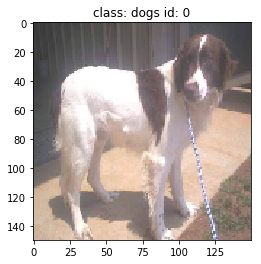

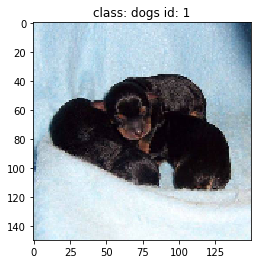

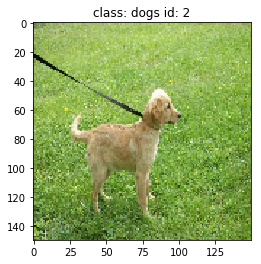

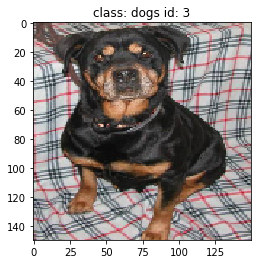

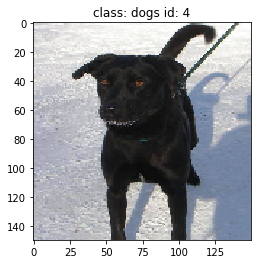

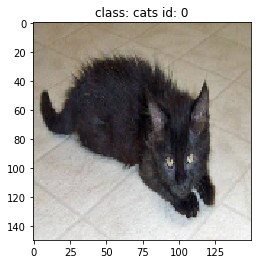

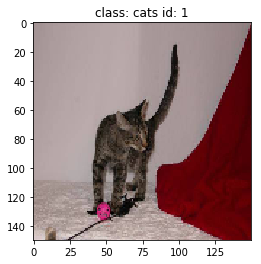

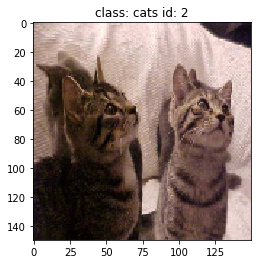

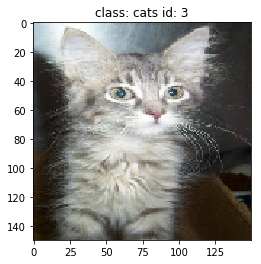

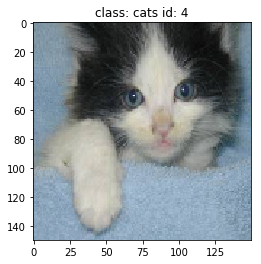

In [4]:
display_batch(batch_dogs, "dogs", limit=5)
display_batch(batch_cats, "cats", limit=5)

In [4]:
batch_dogs.shape

(32, 150, 150, 3)

-----

**Note** We trained the model using an instance of `ImageDataGenerator`.  That instance encondes the label names and ids according to the directory structure of the training images. In order to get the mapping back, we need to run the next block:

-----

In [4]:
# generator: it is only needed for getting the mapping of the class labels (from int id to str label)
train_datagen = ImageDataGenerator(rescale=1./255)      # rescale images by 1/255 
train_dir = "/media/data/dogs_vs_cats_small/train"
train_generator = train_datagen.flow_from_directory(train_dir,                          # path of images
                                                    target_size=(input_h, input_w),     # image size
                                                    batch_size=20,                      # number of images per batch
                                                    class_mode="binary"                 # because you use binary_crossentropy, you need binary labels
                                                    )
# mapping: {'cats': 0, 'dogs': 1}
class_indices = train_generator.class_indices

Found 2000 images belonging to 2 classes.


This is the mapping:

In [5]:
class_indices

{'cats': 0, 'dogs': 1}

-----

**Note** According to [this](https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2) you can get the same mapping as follows:



```python
import numpy as nppredictions = model.predict_generator(self.test_generator)        
predictions = np.argmax(predictions, axis=-1)            # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())     # flip k,v
predictions = [label_map[k] for k in predictions]
```


or as [follows](https://stackoverflow.com/questions/38971293/get-class-labels-from-keras-functional-model) :

```python
from glob import glob
class_names = glob("*") # Reads all the folders in which images are present
class_names = sorted(class_names) # Sorting them
name_id_map = dict(zip(class_names, range(len(class_names))))
```

------

Keras provides several functions for prediction. Here, we review three of them:


```
predict(): Generates output predictions for the input samples. Returns Numpy array(s) of predictions.
```
[source](https://keras.io/models/sequential/)


```
predict_classes(): Generate class predictions for the input samples batch by batch. Returns an integer numpy array of class predictions.
predict_proba(): Generates class probability predictions for the input samples batch by batch. Returns a Numpy array of probability predictions.
```
[source](http://faroit.com/keras-docs/1.0.0/models/sequential/)


**Note** Check [this discussion](https://github.com/keras-team/keras/issues/2524) for more information about these two last methods.


For some reason, the last two functions does not appear in the documentation of Keras 2.0 (I am using 2.2.5). However, they are still in the API. According to [this post](https://stackoverflow.com/questions/51382524/what-is-the-difference-between-predict-and-predict-class-functions-in-keras):

- `predict` is for regression problems (outputs are float values).
- `predict_classes` is for classification problems (outputs are int labels).


It turns out that both `predict_classes()` and `predict_proba()` rely in `predict()`. The code of these functions is located at:

```
/home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/engine/sequential.py
```

Here is the code:


```python
def predict_classes(self, x, batch_size=32, verbose=0):
    """Generate class predictions for the input samples.

    The input samples are processed batch by batch.

    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        batch_size: integer.
        verbose: verbosity mode, 0 or 1.

    # Returns
        A numpy array of class predictions.
    """
    proba = self.predict(x, batch_size=batch_size, verbose=verbose)
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > 0.5).astype('int32')
```

As it can be seen, this function first calls `self.predict()` to get `proba` (the output of the network). The output is then processed according to its rank (i.e., number of dimensios):

- If the last dimension is greater than 1, the output (`proba`) encodes multiples classes.
- Otherwise, the output (`proba`) encondes two clases. 

For the first case, the probabilities are converted to integer labels as follows:

```
proba.argmax(axis=-1)
```

For the second case, the probabilities are converted to integer labels as follows (a very clever way to do it, IMO):

```
return (proba > 0.5).astype('int32')
```

Here, we are dealing with a binary-classification problem. So, we will use `predict_classes`. Just for completeness, here is the code of `predict_proba`:


```python
def predict_proba(self, x, batch_size=32, verbose=0):
    """Generates class probability predictions for the input samples.

    The input samples are processed batch by batch.

    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        batch_size: integer.
        verbose: verbosity mode, 0 or 1.

    # Returns
        A Numpy array of probability predictions.
    """
    preds = self.predict(x, batch_size, verbose)
    if preds.min() < 0. or preds.max() > 1.: 
        warnings.warn('Network returning invalid probability values. '
                      'The last layer might not normalize predictions '
                      'into probabilities '
                      '(like softmax or sigmoid would).')
    return preds
```

As it can be seen, this function calls `self.predict()` to get the output of the model (`preds`). Then, it perform a sanity check.


In the following, we use `predict_classes` to predict the label of unseen images.

In [7]:
# load model
model = load_model("dogs_vs_cats_small_v1.h5")

# prediction
pred_dogs = model.predict(batch_dogs)
pred_cats = model.predict(batch_cats)

In [8]:
# cast to int
pred_dogs_classes = (pred_dogs > 0.5).astype("int32").flatten()
pred_cats_classes = (pred_cats > 0.5).astype("int32").flatten()

These are the predictions:

In [9]:
pred_dogs_classes

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int32)

In [10]:
pred_cats_classes

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

and the missclassified samples:

In [11]:
class_indices

{'cats': 0, 'dogs': 1}

In [12]:
error_dogs = (pred_dogs_classes != class_indices["dogs"]).sum()
print("missclassified dogs:", error_dogs)

missclassified dogs: 11


In [13]:
error_cats = (pred_cats_classes != class_indices["cats"]).sum()
print("missclassified cats:", error_cats)

missclassified cats: 9


In the next section, we show how to classify a single batch using a generator, i.e., an instance of `ImageDataGenerator`, rather than creating a list of images manually.

## Classify a single batch using `ImageDataGenerator`

From the [documentation](https://keras.io/preprocessing/image/):

```python
flow_from_directory(directory,
                    target_size=(256, 256), 
                    color_mode='rgb', 
                    classes=None, 
                    class_mode='categorical', 
                    batch_size=32, 
                    shuffle=True, 
                    seed=None, 
                    save_to_dir=None, 
                    save_prefix='', 
                    save_format='png', 
                    follow_links=False, 
                    subset=None, 
                    interpolation='nearest')
```

Takes the path to a directory & generates batches of augmented data.

**Arguments**

- `directory`: String, path to the target directory. It should contain one subdirectory per class.
- `target_size`: Tuple of integers `(height, width)`. The dimensions to which all images found will be resized.
- `color_mode`: One of `"grayscale"`, `"rgb"`, `"rgba"`.
- `classes`: Optional list of class subdirectories (e.g., `["dogs", "cats"]`). If not provided, the list of classes will be automatically inferred from the subdirectory names under `directory`.
- `class_mode`: One of `"categorical"`, `"binary"`, `"sparse"`, `"input"` or `None`. Determines the type of label arrays that are returned.
- `batch_size`: Size of the batches of data.
- `shuffle`: Whether to shuffle the data. If set to `False`, sorts the data in alphanumeric order. **Tip: Set `True` for training and validation, and `False` for testing**
- `seed`: Optional random seed for shuffling and transformations.
- `save_to_dir`: `None` or string. This allows you to optionally specify a directory to which to save the augmented pictures being generated (useful for visualizing what are you doing).
- `save_prefix`:  String prefix to use for filenames of saved pictures (only relevant if `save_to_dir`) is set.
- `follow_links`: Whether to follow symlinks inside class subdirectories.
- `subset`: Subset of data (`"training"` or `"validation"`) if `"validation_split"` is set in `ImageDataGenerator`.
- `interpolation`: Interpolation method used to resample the image if the target size if different from that of the loaded image. Some options: `"nearest"`, `"bilinear"`, `"bicubic"`, `"lanczsos"` (requires PIL 1.1.3), `"box"` and `"hamming"` (requires PIL 3.4.0).




In [27]:
# create image data generator to preprocess input images
test_dir = "/media/data/dogs_vs_cats_small/test"              # we assume this path contains a directory for each class
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,                         # path of test images
                                                  target_size=(input_h, input_w),   # shape expected by the model
                                                  color_mode="rgb",
                                                  class_mode="binary",
                                                  batch_size=32,
                                                  shuffle=False,
                                                  seed=42,
                                                 )

Found 1000 images belonging to 2 classes.


In [15]:
test_generator.filenames

['cats/cat.1500.jpg',
 'cats/cat.1501.jpg',
 'cats/cat.1502.jpg',
 'cats/cat.1503.jpg',
 'cats/cat.1504.jpg',
 'cats/cat.1505.jpg',
 'cats/cat.1506.jpg',
 'cats/cat.1507.jpg',
 'cats/cat.1508.jpg',
 'cats/cat.1509.jpg',
 'cats/cat.1510.jpg',
 'cats/cat.1511.jpg',
 'cats/cat.1512.jpg',
 'cats/cat.1513.jpg',
 'cats/cat.1514.jpg',
 'cats/cat.1515.jpg',
 'cats/cat.1516.jpg',
 'cats/cat.1517.jpg',
 'cats/cat.1518.jpg',
 'cats/cat.1519.jpg',
 'cats/cat.1520.jpg',
 'cats/cat.1521.jpg',
 'cats/cat.1522.jpg',
 'cats/cat.1523.jpg',
 'cats/cat.1524.jpg',
 'cats/cat.1525.jpg',
 'cats/cat.1526.jpg',
 'cats/cat.1527.jpg',
 'cats/cat.1528.jpg',
 'cats/cat.1529.jpg',
 'cats/cat.1530.jpg',
 'cats/cat.1531.jpg',
 'cats/cat.1532.jpg',
 'cats/cat.1533.jpg',
 'cats/cat.1534.jpg',
 'cats/cat.1535.jpg',
 'cats/cat.1536.jpg',
 'cats/cat.1537.jpg',
 'cats/cat.1538.jpg',
 'cats/cat.1539.jpg',
 'cats/cat.1540.jpg',
 'cats/cat.1541.jpg',
 'cats/cat.1542.jpg',
 'cats/cat.1543.jpg',
 'cats/cat.1544.jpg',
 'cats/cat

See page 136 to review how a generator works. You will find an example as follows (**do not forget to use `break`**):

data batch shape:    (32, 150, 150, 3)
labels batch shape:  (32,)
first labels:        [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


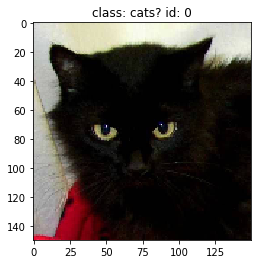

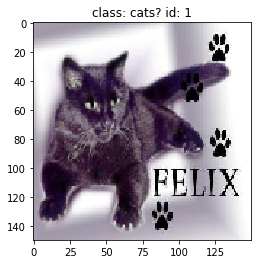

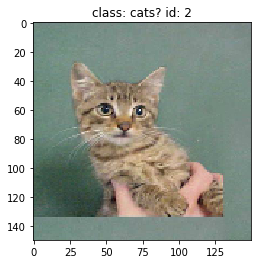

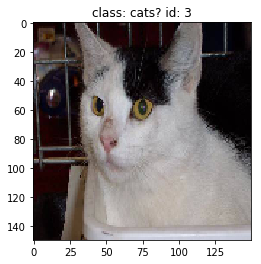

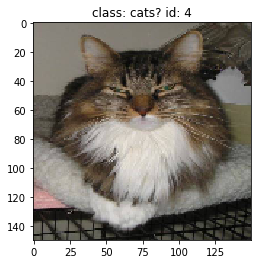

In [28]:
for batch, labels in test_generator:
    print("data batch shape:   ", batch.shape)
    print("labels batch shape: ", labels.shape)
    print("first labels:       ", labels[:10])
    
    display_batch(batch, "cats?", limit=5)

    break  # do not forget this!

The following block classifies the first batch of images:

missclassified: 7


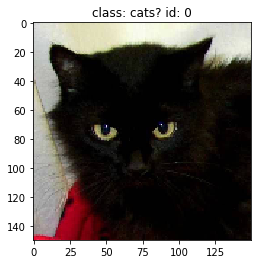

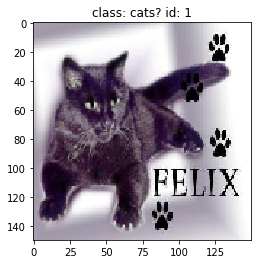

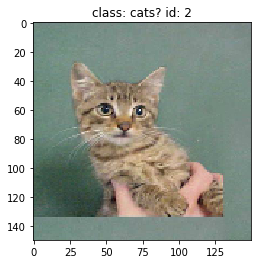

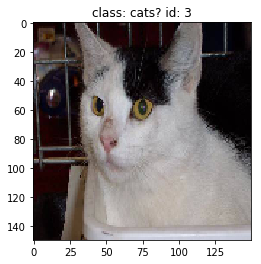

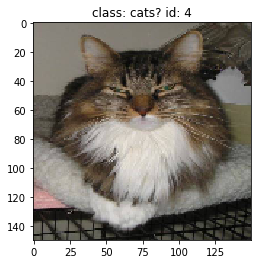

In [35]:
# this line is needed to yield the batches from the top
test_generator.reset()

for batch, labels in test_generator:
    
    # get predictions
    pred = model.predict(batch)
    
    # debug
    #print(labels)
    #print(pred)
    
    # cast to int
    pred = (pred > 0.5).astype("int32").flatten()
    
    # measure error (missclassified samples)
    error = (pred != labels).sum()
    print("missclassified:", error)
    
    display_batch(batch, "cats?", limit=5)
    
    # stop classification
    break

So, there are a few missclassified samples, in this case, 7 images. The next block displays the misclassified images:

-----

**Note** You may notice that, if you run the above block twice, the output of the network is different (try commenting `test_generator.reset()`). That is because the generator is yielding a different batch of images each time. For that reason, the model return a different result each time.

You can reset the generator using `generator.reset()`, as suggested [here](https://stackoverflow.com/questions/56298011/how-to-reset-keras-data-generator-in-r). If you are curious about how this works, check the code in:

```
/home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras_preprocessing/image/iterator.py
```

as suggested by this message:

```
print(test_generator.reset)
<bound method Iterator.reset of <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x7fc535d40ac8>>
```

This is the code:

```python
# iterator.py

def reset(self):
    self.batch_index = 0
```

-----

The next block displays the missclassified images

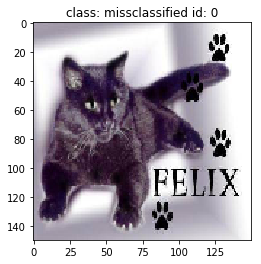

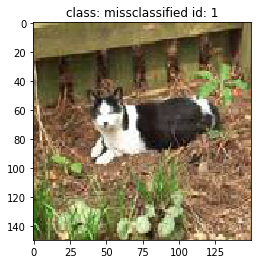

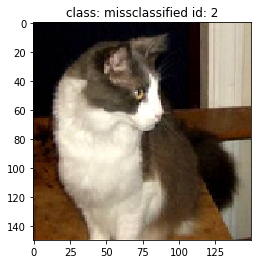

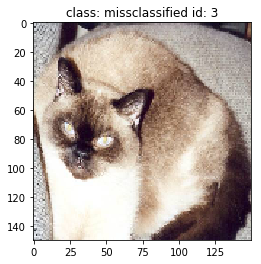

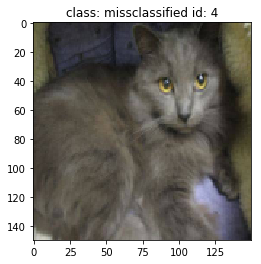

In [42]:
miss = None

# to start from the first batch
test_generator.reset()

for batch, labels in test_generator:
    
    # get predictions
    pred = model.predict(batch)
    
    # debug
    #print(labels)
    #print(pred)
    
    # cast to int
    pred = (pred > 0.5).astype("int32").flatten()
    
    # measure error (missclassified samples)
    to_keep = pred != labels
    
    # missclassified samples
    miss = batch[to_keep]
    
    display_batch(miss, "missclassified", limit=5)
    
    # stop classification
    break

Let's get a closer view of the missclassified samples. We know that the first batch comprises cats samples only. Thus, the model missclassified them as dogs. The probabilities (sigmoid values) of the missclassified samples are the following:

In [44]:
# get predictions of missclassified samples
pred = model.predict(miss)
print(pred)

[[0.97795093]
 [0.9972951 ]
 [0.90946865]
 [0.9412052 ]
 [0.63507265]
 [0.9891282 ]
 [0.7446711 ]]


Surprisingly, the probabilities are considerable high. That is, the model seems to be very confident that these cats are dogs.

In [45]:
pred_int = (pred > 0.5).astype("int32").flatten()

In [47]:
pred_int

array([1, 1, 1, 1, 1, 1, 1], dtype=int32)

## Classify a whole split using `ImageDataGenerator` (multiple batches)

Now that we are familiar with `ImageDataGenerator`, `flow_from_directory`, and know how to uses batches, we will predict the images in the testing split using multiple batches.

Here, we will yield batches of `batch_size=20` samples per batch. There are 1000 images of cats and dogs, so there 1000/20 = 50 different batches. This is the value of `steps`. From the [documentation](https://keras.io/models/sequential/):

```python
predict_generator(generator, 
                  steps=None, 
                  callbacks=None, 
                  max_queue_size=10, 
                  workers=1, 
                  use_multiprocessing=False, 
                  verbose=0)
```

Generates predictions for the input samples from a data generator. Returns array(s)
 of predictions.
 
**Arguments**

- `generator` Generator yielding batches of input samples or an instance of `Sequence` (`keras.utils.Sequence`) object in order to avoid duplicate data when using multiprocessing.
- `steps` Total number of steps (batches of samples) to yield from `generator` before stopping. Optional for `Sequence`: if unspecified, will use the `len(generator)` as number of steps.
- `callbacks` List of `keras.callbacks.Callback` instances to apply during training (testing?).
- `max_queue_size` Maximum size for the generator queue.
- `workers` Maximum number of processes to spin up when using process based threading.
- `use_multiprocessing` If `True`, use process-based threading.
- `verbose` Verbosity mode, `0` or `1`.

In [50]:
n_images = 1000
batch_size = 20
steps = int(n_images/batch_size)


# create image data generator to preprocess input images
test_dir = "/media/data/dogs_vs_cats_small/test"              # we assume this path contains a directory for each class
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,                         # path of test images
                                                  target_size=(input_h, input_w),   # shape expected by the model
                                                  color_mode="rgb",
                                                  class_mode="binary",
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42,
                                                 )

Found 1000 images belonging to 2 classes.


In [51]:
pred = model.predict_generator(test_generator, steps=steps)

In [53]:
pred.shape

(1000, 1)

Now, let's check how many images are missclassified (this is my code, I am not sure if it is correct):

In [59]:
# real labels (I am not sure about this part)
real_labels = test_generator.labels

# cast to labels
pred_int = (pred > 0.5).astype("int32").flatten()

# errors (missclassified images)
error = (pred_int != real_labels).sum()
print("misclassified images %d/%d (%.4f)" % (error, n_images, (error/n_images)))

misclassified images 281/1000 (0.2810)


The model failed to classify 281 of 1000 images. Before going deeper, let's see the prediction values (probabilities) of the first and last images:

In [60]:
pred[[0, -1], :]

array([[1.7881393e-07],
       [9.8407125e-01]], dtype=float32)

Now, let's create a batch with these images to verify that the generator yields all the images:

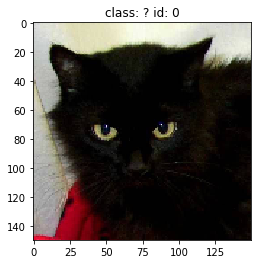

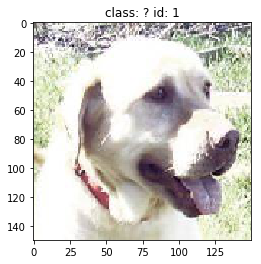

In [62]:
fnames = [test_generator.filepaths[0],    # first image
          test_generator.filepaths[-1]]   # last image 
mini_batch = create_batch(fnames)
display_batch(mini_batch, "?", limit=2)

In [63]:
mini_pred = model.predict(mini_batch)

In [64]:
mini_pred

array([[1.2396187e-07],
       [9.8407125e-01]], dtype=float32)

As it can be seen, both `pred` and `mini_pred` are the same. So, we can conclude that the generator yields all the images to the model.